# Naive Bayes for Text Data and Record Data

## Introduction to Naive Bayes

Naive Bayesian algorithm is a classification algorithm designed based on conditional probability. Its underlying logic is Bayesian posterior probability, so it becomes a Bayesian classifier. The mathematical form of the problem can be written as:

$$
P(B|A) = \frac{P(A \cap B)}{P(A)}
$$

The parameters in the formula will be defined as below.

   We define Y as the classification of sample points. Here, we assume that the value of Y is discrete, and X represents the characteristics of the sample. In general, we can often know the proportion of certain characteristics in a certain category. So our ultimate goal is to get the final value of , which means the probability that the sample point is of classification Y given the character X. By analyzing the distribution of the population, we can directly use the proportion of different values of X in the population to approximate the overall  and use the proportion of different X in a given category Y to represent the . The purpose of the algorithm is to calculate the conditional probabilities of a given X in different kinds by iteration, and take the maximum conditional probability as the classification of the sample point.
   
   To be noticed, the algorithm requires the data set to be as large as possible to ensure the training data can represent the population in general case.

## Preparations

First import relevant packages for this task.

In [ ]:
import matplotlib.pyplot as plt
import wikipedia
import nltk
import string 
from nltk.stem import WordNetLemmatizer
from nltk.stem import PorterStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
import numpy as np
from sklearn.metrics import accuracy_score

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB

Read the "free_mtr_text_data.csv" file from the data cleaning part. 

You can access to this data here:\
https://github.com/anly501/anly-501-project-WilliamChuFCB/tree/main/data/cleaned_data

After read in the csv file, I also transform the string labels to integer labels for further modeling.

In [ ]:
df=pd.read_csv('free_mtr_text_data.csv')  
print("shape of the dataset:")
print(df.shape)

#CONVERT FROM STRING LABELS TO INTEGERS 
labels=[]
y1=[]
for label in df["label"]:
    if label not in labels:
        labels.append(label)
        print("index =",len(labels)-1,": label =",label)
    for i in range(0,len(labels)):
        if(label==labels[i]):
            y1.append(i)
y1=np.array(y1)

# CONVERT DF TO LIST OF STRINGS 
textdata=df["text"].to_list()

print("number of text chunks = ",len(textdata))
print("-------------------")
print("examples of the data:")
print(textdata[0:3])


shape of the dataset:
(3465, 2)
index = 0 : label = freeway
index = 1 : label = metro
number of text chunks =  3465
-------------------
examples of the data:
['boenau rfsdfhsfbhwsfgb least ca expressway might limited access still grade inte http co dibmsr9b5b', 'zacakamadu sudden urge go san jose talk cultural impact song unfortunately san jo http co nujnntbhx0', 'alinaaaziz yes girl freeway system wack lol']


Then, vectorize the data and transform it into onehot matrix.

In [ ]:
# INITIALIZE COUNT VECTORIZER
vectorizer=CountVectorizer(min_df=5)   

# RUN COUNT VECTORIZER ON OUR COURPUS 
vec=vectorizer.fit_transform(textdata)   
dense=np.array(vec.todense())

#CONVERT TO ONE-HOT VECTORS
maxs=np.max(dense,axis=0)
onehot=np.ceil(dense/maxs)

# DOUBLE CHECK 
print("shape of onehot matrix:")
print(onehot.shape)

shape of onehot matrix:
(3465, 1332)


## Basic EDA for the text data

Create a heat map to visualize the distance matrix:

(250, 250)
[[0.         0.16903085 0.11952286 ... 0.         0.         0.        ]
 [0.16903085 0.         0.30304576 ... 0.         0.28571429 0.26726124]
 [0.11952286 0.30304576 0.         ... 0.         0.20203051 0.18898224]
 ...
 [0.         0.         0.         ... 0.         0.18898224 0.1767767 ]
 [0.         0.28571429 0.20203051 ... 0.18898224 0.         0.40089186]
 [0.         0.26726124 0.18898224 ... 0.1767767  0.40089186 0.        ]]


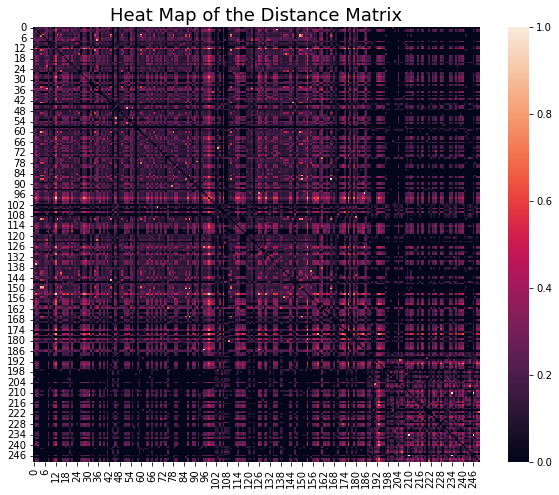

In [ ]:
num_rows_keep=250
index=np.sort(np.random.choice(onehot.shape[0], num_rows_keep, replace=False))
tmp1=onehot[index, :]

#COMPUTE DISTANCE MATRIX
dij=[]

#LOOP OVER ROWS
for i in range(0,tmp1.shape[0]):
    tmp2=[]
    #LOOP OVER ROWS
    for j in range(0,tmp1.shape[0]):

        #EXTRACT VECTORS
        vi=tmp1[i,:]
        vj=tmp1[j,:]

        #COMPUTE DISTANCES
        dist=np.dot(vi, vj)/(np.linalg.norm(vi)*np.linalg.norm(vj)) 
        
        # BUILD DISTANCE MATRIX
        if(i==j or np.max(vi) == 0 or np.max(vj)==0):
            tmp2.append(0)
        else:
            tmp2.append(dist)
    dij.append(tmp2)
        
dij=np.array(dij)

import seaborn as sns
fig,axes = plt.subplots(1, 1, num="stars",figsize=(10, 8))
plot1=sns.heatmap(dij, annot=False)
plot1.set_title("Heat Map of the Distance Matrix", fontsize=18)
print(dij.shape)
print(dij)


This is a heatmap of distance matrix of sentence vectors for a subset of the data.

Next, perform PCA on this data and visualize the distribution of the data on first two and three principle components  respectively using 2-D and 3-D scatter plot. Also, draw a pairplot for first ten principle components.

[0.07857278 0.05298973 0.02185908 0.01781894 0.01384257 0.01342373
 0.01034756 0.00872622 0.00811426 0.00747515]
[43.26549563 35.53051175 22.82031075 20.60376245 18.1599245  17.88307279
 15.70090348 14.41845457 13.90369045 13.34490494]


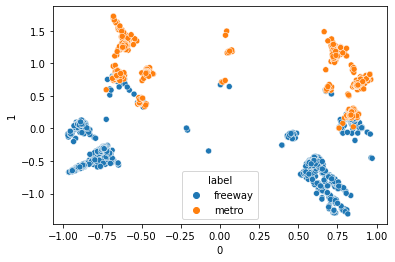

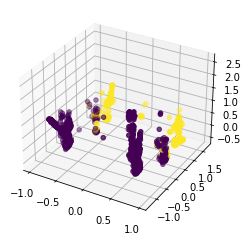

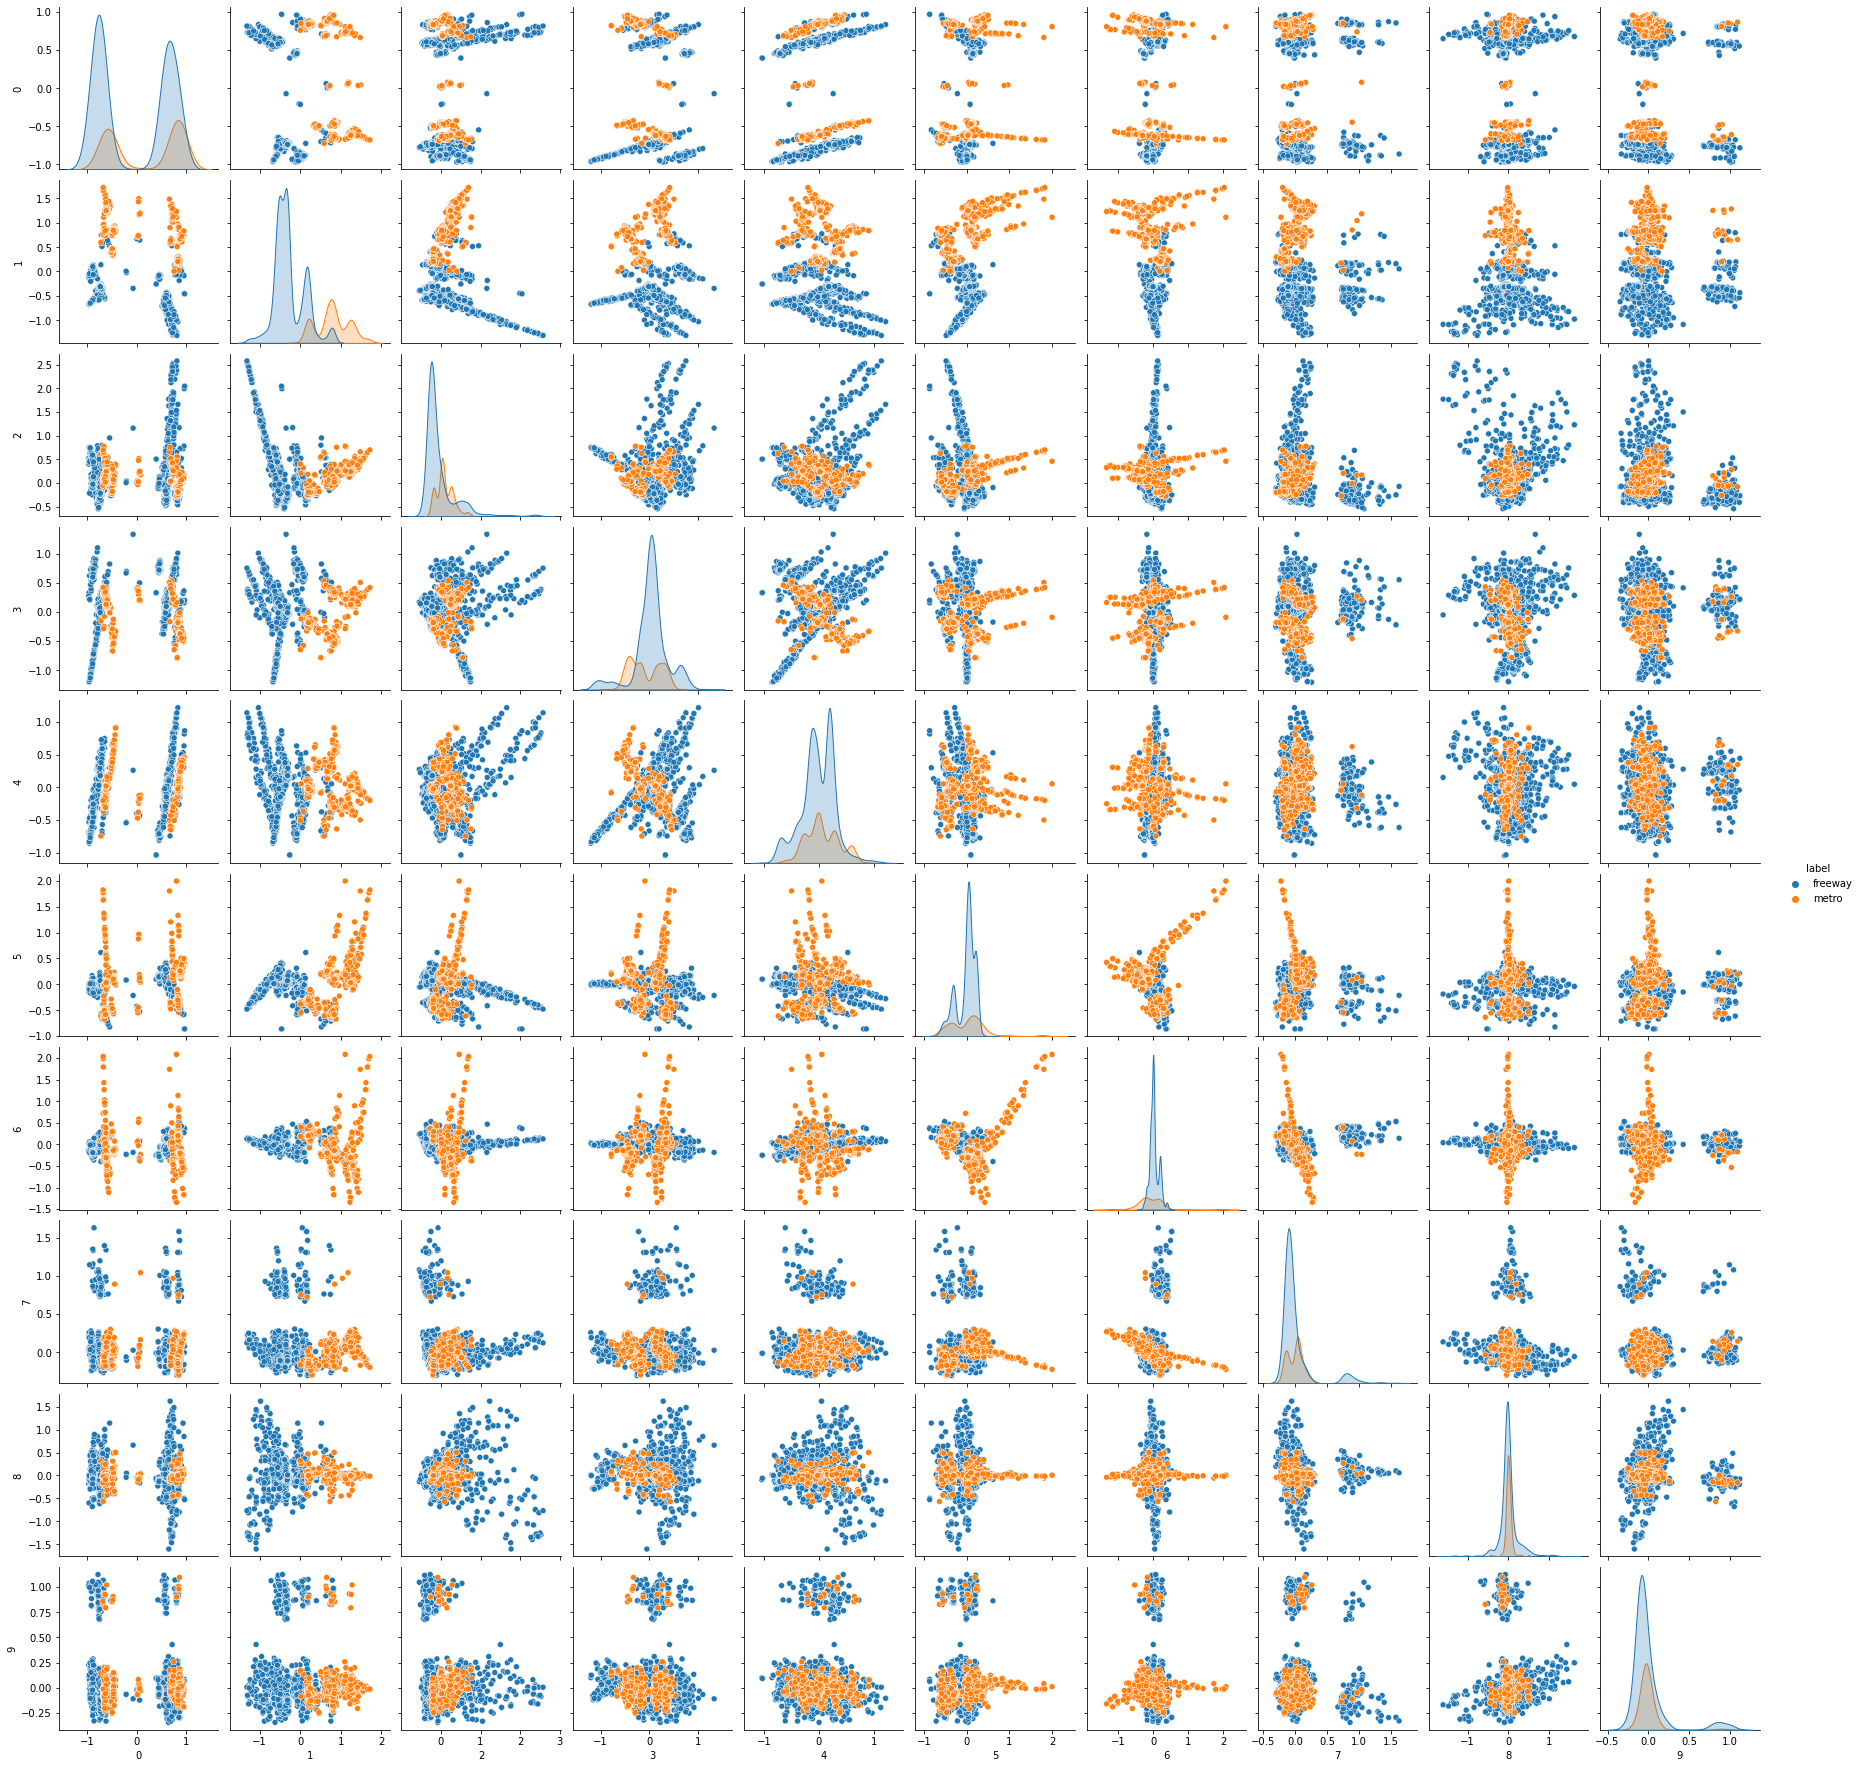

In [ ]:
from sklearn.decomposition import PCA

# COMPUTE PCA WITH 10 COMPONENTS
pca = PCA(n_components=10)
pca.fit(onehot)
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

# GET PRINCIPLE COMPONENT PROJECTIONS 
principal_components = pca.fit_transform(onehot)
df2 = pd.DataFrame(data = principal_components) 
df3=pd.concat([df2,df['label']], axis=1)

# FIRST TWO COMPONENTS
sns.scatterplot(data=df2, x=0, y=1,hue=df["label"]) 
plt.show()

#3D PLOT
ax = plt.axes(projection='3d')
ax.scatter3D(df2[0], df2[1], df2[2], c=y1);
plt.show()

#PAIRPLOT
plot2=sns.pairplot(data=df3,hue="label") 
#plt.show()

According to the visualizations above, we can see that there exists obvious difference in data distribution of two labels of data. I will further use Naive Bayes to figure out if I can create a classification model with high accuracy based on this data.

## Naive Bayes for text data

In order to establish the Naive Bayes model, we need to split the data into training and testing sets.

In [ ]:
#split to train data and test data

X=onehot
test_ratio=0.2
x_train, x_test, y_train, y_test = train_test_split(X, y1, test_size=test_ratio, random_state=0)
y_train=y_train.flatten()
y_test=y_test.flatten()

print("x_train.shape		:",x_train.shape)
print("y_train.shape		:",y_train.shape)

print("X_test.shape		:",x_test.shape)
print("y_test.shape		:",y_test.shape)

x_train.shape		: (2772, 1332)
y_train.shape		: (2772,)
X_test.shape		: (693, 1332)
y_test.shape		: (693,)


Train the model with Naive Bayes algorithm and predict on the testing set.

In [ ]:
# INITIALIZE MODEL 
model = MultinomialNB()

# TRAIN MODEL 
model.fit(x_train,y_train)

yp_train = model.predict(x_train)
yp_test = model.predict(x_test)


Print the results of model prediction.

In [ ]:
def report(y,ypred):
    #ACCURACY COMPUTE 
    print("Accuracy:",accuracy_score(y, ypred)*100)
    print("Number of mislabeled points out of a total %d points = %d"
            % (y.shape[0], (y != ypred).sum()))

def print_model_summary():
    # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
    print("ACCURACY CALCULATION\n")

    print("TRAINING SET:")
    report(y_train,yp_train)

    print("\nTEST SET (UNTRAINED DATA):")
    report(y_test,yp_test)

    print("\nCHECK FIRST 20 PREDICTIONS")
    print("TRAINING SET:")
    print(y_train[0:20])
    print(yp_train[0:20])
    print("ERRORS:",yp_train[0:20]-y_train[0:20])

    print("\nTEST SET (UNTRAINED DATA):")
    print(y_test[0:20])
    print(yp_test[0:20])
    print("ERRORS:",yp_test[0:20]-y_test[0:20])
    

print_model_summary()

ACCURACY CALCULATION

TRAINING SET:
Accuracy: 96.64502164502164
Number of mislabeled points out of a total 2772 points = 93

TEST SET (UNTRAINED DATA):
Accuracy: 93.93939393939394
Number of mislabeled points out of a total 693 points = 42

CHECK FIRST 20 PREDICTIONS
TRAINING SET:
[1 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0]
[0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 1 0 0]
ERRORS: [-1  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]

TEST SET (UNTRAINED DATA):
[1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1]
[1 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1]
ERRORS: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


We can see that the prediction accuracy on the test dataset is 93.9%, which is very high. This means the model perform quite well on this dataset.

I further measure the prediction result using confusion matrix.

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, yp_test.round()))
print("-----------------------")
print(classification_report(y_test, yp_test.round()))

Confusion Matrix:
[[498  21]
 [ 21 153]]
-----------------------
              precision    recall  f1-score   support

           0       0.96      0.96      0.96       519
           1       0.88      0.88      0.88       174

    accuracy                           0.94       693
   macro avg       0.92      0.92      0.92       693
weighted avg       0.94      0.94      0.94       693



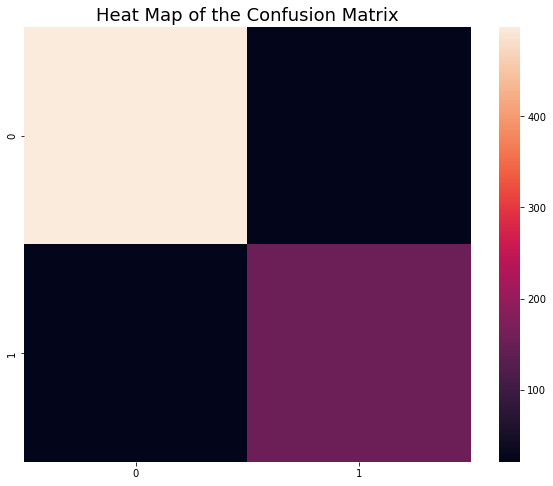

In [ ]:
confu=confusion_matrix(y_test, yp_test.round())
fig,axes = plt.subplots(1, 1, num="stars",figsize=(10, 8))
plot3=sns.heatmap(confu)
plot3.set_title("Heat Map of the Confusion Matrix", fontsize=18)
plt.savefig("confusion matrix py.png")

This is a heat map of confusion matrix. The grids on top right-hand corner and left lower corner is black, which indicates that this model make few mistakes on the testing dataset.

## Basic EDA for record data

In this part, I will use record data to train the Naive Bayes model. First read the csv file "travel_mode_choice.csv"

You can find this cleaned data here:\
https://github.com/anly501/anly-501-project-WilliamChuFCB/tree/main/data/cleaned_data

In [ ]:
df2=pd.read_csv("travel_mode_choice.csv")
X=np.array(df2)
df2.iloc[:10,:]

,TTME,INVC,INVT,GC,HINC,PSIZE,choice
0,40,20,345,57,20,1,2
1,45,148,115,160,45,1,1
2,20,19,325,55,26,1,2
3,15,38,255,66,26,1,2
4,20,21,300,54,6,1,2
5,45,18,305,51,20,1,2
6,10,28,305,75,72,2,2
7,20,21,305,54,6,1,2
8,45,45,465,116,10,2,2
9,90,142,105,153,50,1,1


Draw a heat map of correlation matrix of this data:

            TTME      INVC      INVT        GC      HINC    PSIZE     choice
TTME    1.000000  0.464165 -0.152421  0.309941  0.142177  0.070189 -0.384252
INVC    0.464165  1.000000 -0.429092  0.550372  0.362047 -0.040891 -0.693269
INVT   -0.152421 -0.429092  1.000000  0.484061 -0.241788 -0.045246  0.678051
GC      0.309941  0.550372  0.484061  1.000000  0.131839  0.079697 -0.057761
HINC    0.142177  0.362047 -0.241788  0.131839  1.000000 -0.017023 -0.294000
PSIZE   0.070189 -0.040891 -0.045246  0.079697 -0.017023  1.000000 -0.078319
choice -0.384252 -0.693269  0.678051 -0.057761 -0.294000 -0.078319  1.000000


Text(0.5, 1.0, 'Heat Map of the Correlation Matrix')

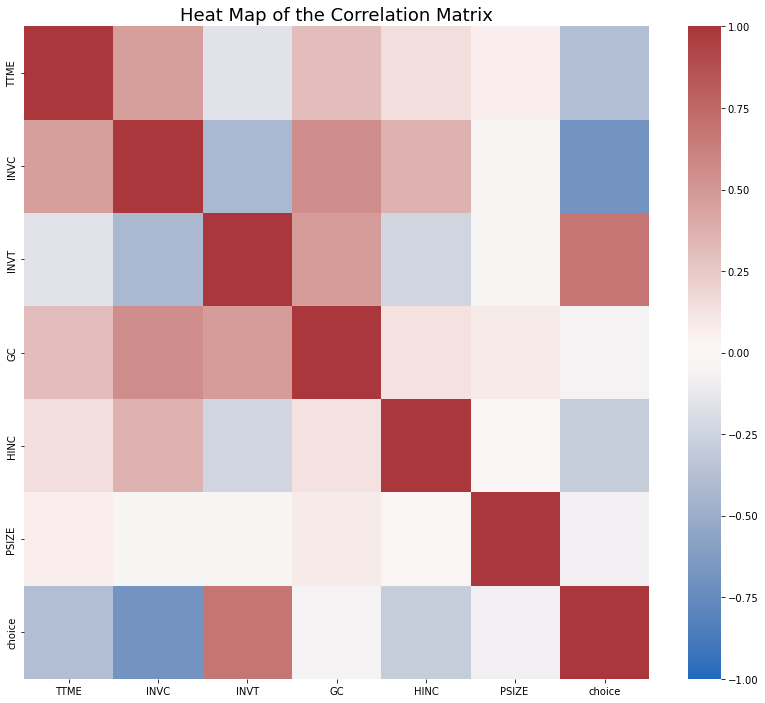

In [ ]:
print(df2.corr())
fig,axes = plt.subplots(1, 1, num="stars",figsize=(14, 12))
axes = sns.heatmap(df2.corr(), vmin=-1, vmax=1,cmap="vlag")
axes.set_title("Heat Map of the Correlation Matrix", fontsize=18)
#plt.show()

## Naive Bayes for record data

Split the data into training and testing sets at 0.2 test ratio:

In [ ]:
#split to train data and test data

y=df2.loc[:,"choice"]
test_ratio=0.2
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=0)
# y_train=y_train.flatten()
# y_test=y_test.flatten()

print("x_train.shape		:",x_train.shape)
print("y_train.shape		:",y_train.shape)

print("X_test.shape		:",x_test.shape)
print("y_test.shape		:",y_test.shape)

x_train.shape		: (120, 7)
y_train.shape		: (120,)
X_test.shape		: (31, 7)
y_test.shape		: (31,)


Train the Naive Bayes model and predict on the testing data:

In [ ]:
# INITIALIZE MODEL 
model = MultinomialNB()

# TRAIN MODEL 
model.fit(x_train,y_train)

yp_train = model.predict(x_train)
yp_test = model.predict(x_test)


Result of the model prediction:

In [ ]:
def report(y,ypred):
    #ACCURACY COMPUTE 
    print("Accuracy:",accuracy_score(y, ypred)*100)
    print("Number of mislabeled points out of a total %d points = %d"
            % (y.shape[0], (y != ypred).sum()))

def print_model_summary():
    # LABEL PREDICTIONS FOR TRAINING AND TEST SET 
    print("ACCURACY CALCULATION\n")

    print("TRAINING SET:")
    report(y_train,yp_train)

    print("\nTEST SET (UNTRAINED DATA):")
    report(y_test,yp_test)


print_model_summary()

ACCURACY CALCULATION

TRAINING SET:
Accuracy: 79.16666666666666
Number of mislabeled points out of a total 120 points = 25

TEST SET (UNTRAINED DATA):
Accuracy: 74.19354838709677
Number of mislabeled points out of a total 31 points = 8


We can see that the accuracy on the test data is 74.2%. Since this data contains three different categories in the target variable, this accuracy is acceptable.

Utilize confusion matrix to further measure the performance of this model:

In [ ]:
print("Confusion Matrix:")
print(confusion_matrix(y_test, yp_test.round()))
print("-----------------------")
print(classification_report(y_test, yp_test.round()))

Confusion Matrix:
[[ 8  0  0]
 [ 0 10  4]
 [ 0  4  5]]
-----------------------
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         8
           2       0.71      0.71      0.71        14
           3       0.56      0.56      0.56         9

    accuracy                           0.74        31
   macro avg       0.76      0.76      0.76        31
weighted avg       0.74      0.74      0.74        31



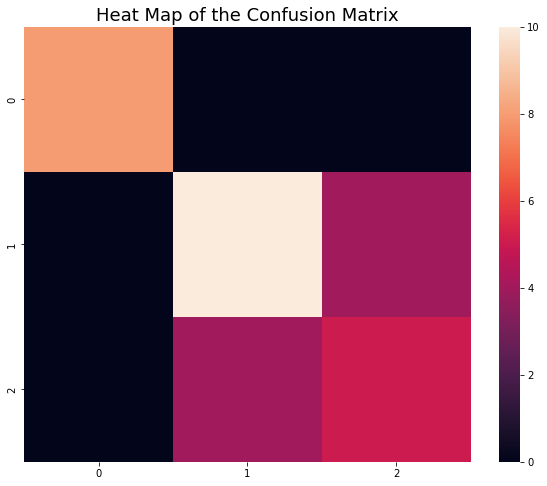

In [ ]:
confu=confusion_matrix(y_test, yp_test.round())
fig,axes = plt.subplots(1, 1, num="stars",figsize=(10, 8))
plot3=sns.heatmap(confu)
plot3.set_title("Heat Map of the Confusion Matrix", fontsize=18)
plt.savefig("confusion matrix py.png")

From this heat map of confusion matrix, we can see that most predictions fall on the diagonal, which means this model performs well.